<a href="https://colab.research.google.com/github/nedokormysh/GB_Libraries_python_for_DS/blob/CourseProject/Libraries_python_DS_CourseWork_dirty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Подключение библиотек

In [ ]:
# Основные библиотеки
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Метрика качества
from sklearn.metrics import r2_score as r2

from scipy.stats import mode

# Разделение датасета
from sklearn.model_selection import train_test_split, cross_val_score


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Оптимизация данных

In [ ]:
def optimizing_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    return df

# Загрузка, предобработка данных

## Функция подсчёта метрик

In [ ]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

## Загрузка данных

In [ ]:
TRAIN_DATASET_PATH = '/content/drive/MyDrive/Libraries_python_DS_CourseWork/train.csv'
TEST_DATASET_PATH = '/content/drive/MyDrive/Libraries_python_DS_CourseWork/test.csv'
SAMPLE_DATASET_PATH = '/content/drive/MyDrive/Libraries_python_DS_CourseWork/sample_submission.csv'

In [ ]:
df_train = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [ ]:
print(f'В обучающем датафрейме {df_train.shape[0]} строк и {df_train.shape[1]} столбцов')

В обучающем датафрейме 10000 строк и 20 столбцов


In [ ]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [ ]:
print(f'В тестовом датафрейме {df_test.shape[0]} строк и {df_test.shape[1]} столбцов')

В тестовом датафрейме 5000 строк и 19 столбцов


### Разница в количестве признаков между train и test

Таким образом выполняется:

In [ ]:
df_train.shape[1] - 1 == df_test.shape[1]

True

## Признаки нашего датасета

In [ ]:
# print('Названия столбцов в обучающем датафрейме\n',df_train.columns)
nl = '\n'
print(f"Названия столбцов в обучающем датафрейме {nl}{df_train.columns}")

Названия столбцов в обучающем датафрейме 
Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')


**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

Задача регрессии на прогнозирование стоимости домов. Метрикой является коэффициент корреляции R2.

Наблюдения - это строки. Признаки - столбцы.

In [ ]:
# df_train.index

In [ ]:
# df_train.dtypes

## Уменьшение объема памяти, который занимает датасет

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
df_train = reduce_mem_usage(df_train)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [ ]:
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


##Приведение типов.

In [ ]:
df_train.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [ ]:
df_train['Id'] = df_train['Id'].astype(str)
df_train['DistrictId'] = df_train['DistrictId'].astype(str)
df_train['Ecology_2'] = df_train['Ecology_2'].astype(str)
df_train['Ecology_3'] = df_train['Ecology_3'].astype(str)
df_train['Shops_2'] = df_train['Shops_2'].astype(str)

In [ ]:
df_train.dtypes

Id                 object
DistrictId         object
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2          object
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [ ]:
num_feat = list(df_train.select_dtypes(exclude='object').columns)
# obj_feat = list(df_train.select_dtypes(include=('object', 'category')).columns)
nom_feat = list(df_train.select_dtypes(include='object').columns)
target = 'Price'

print(f'Числовые признаки: {num_feat}')
# print(f'Нечисловые признаки: {obj_feat}')
print(f'Номинативные признаки: {nom_feat}')

Числовые признаки: ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Price']
Номинативные признаки: ['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']


#EDA и очистка данных

## Удаление дубликатов

In [ ]:
df_train.shape

(10000, 20)

In [ ]:
df_train = df_train.drop_duplicates()
df_train.shape

(10000, 20)

Дубликатов нет.

## Обработка пропусков

Стоит помнить, что в случае, если пропусков у признака слишком много (более 70%), такой признак удаляют. Проверим, насколько полны наши признаки: метод isnull() пройдется по каждой ячейке каждого столбца и определит, кто пуст, а кто нет, составив датафрейм такого же размера, состоящий из True / False. Метод mean() суммирует все значения True, определит концентрацию пропусков в каждом столбце. На 100 мы умножаем, чтобы получить значение в процентах:

In [ ]:
df_train.isnull().mean() * 100

Id                0.00
DistrictId        0.00
Rooms             0.00
Square            0.00
LifeSquare       21.13
KitchenSquare     0.00
Floor             0.00
HouseFloor        0.00
HouseYear         0.00
Ecology_1         0.00
Ecology_2         0.00
Ecology_3         0.00
Social_1          0.00
Social_2          0.00
Social_3          0.00
Healthcare_1     47.98
Helthcare_2       0.00
Shops_1           0.00
Shops_2           0.00
Price             0.00
dtype: float64

В данном случае у нас нет признаков с более 70 процентами пропусков, таких, что мы могли бы выбросить

https://www.helenkapatsa.ru/razvedochnyy-analiz-dannykh-chast-1/

## Распределение целевой переменной

In [ ]:
# round(df_train['Price'].mean(), 2)
# round(df_train.Price.median(), 2)
# round(df_train.Price.mode()[0], 2)

In [ ]:
# mode(df_train.Price)[0][0]

In [ ]:
# df_train.Price.head()

In [ ]:
target_mean = round(df_train['Price'].mean(), 2)
target_median = round(df_train.Price.median(), 2)
target_mode = df_train['Price'].mode()[0]

In [ ]:
print(f'Среднее значение целевой переменной = {target_mean}')
print(f'Медиана целевой переменной = {target_median}')
print(f'Мода целевого значения = {target_mode}')

Среднее значение целевой переменной = 214138.94
Медиана целевой переменной = 192269.66
Мода целевого значения = 182938.078125


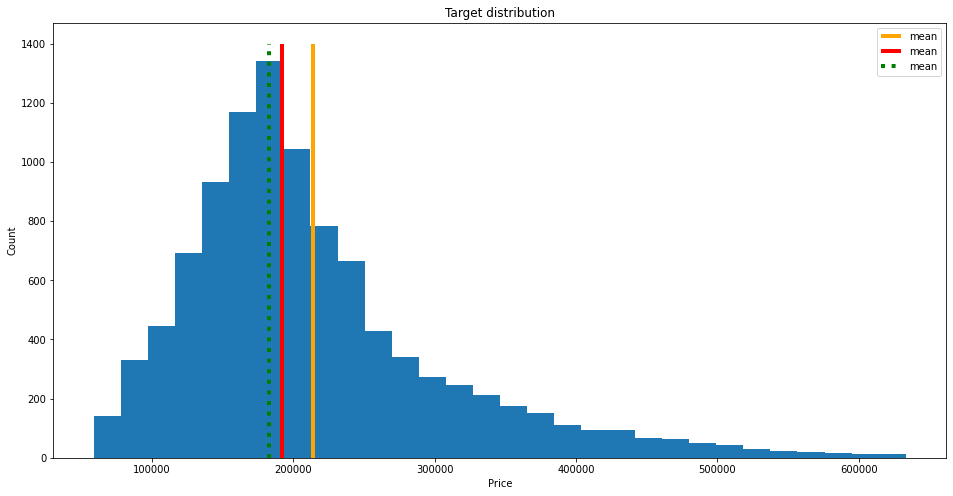

In [ ]:
plt.figure(figsize = (16, 8))

y = df_train['Price']
plt.hist(y, bins=30)
# df_train['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

# plt.plot([target_mean] * 1400, y, label='mean',  linewidth=4)
# plt.plot([target_median] * 10, y, label='median',  linewidth=4)
# plt.plot([target_mode] * 10, y, label='mode', linewidth=4)

plt.vlines(target_mean, 0, 1400, label='mean', linewidth=4, colors='orange')
plt.vlines(target_median, 0, 1400, label='mean', linewidth=4, colors='red')
plt.vlines(target_mode, 0, 1400, label='mean', linewidth=4, colors='green', linestyle=':')

plt.title('Target distribution')
plt.legend()
plt.show()

Первоначально выбросов в целевой переменной нет. Несимметричное распределение.

In [ ]:
# plt.figure(figsize = (16, 8))

# sns.distplot(df_train['Price'], bins=30)

# y = np.linspace(0, 0.000005, 10)
# plt.plot([target_mean] * 10, y, label='mean',  linewidth=4)
# plt.plot([target_median] * 10, y, label='median',  linewidth=4)
# plt.plot([target_mode] * 10, y, label='mode', linewidth=4)
# # print(y.shape)

# plt.title('Distribution of median_house_value')
# plt.legend()
# plt.show()

## Корреляция

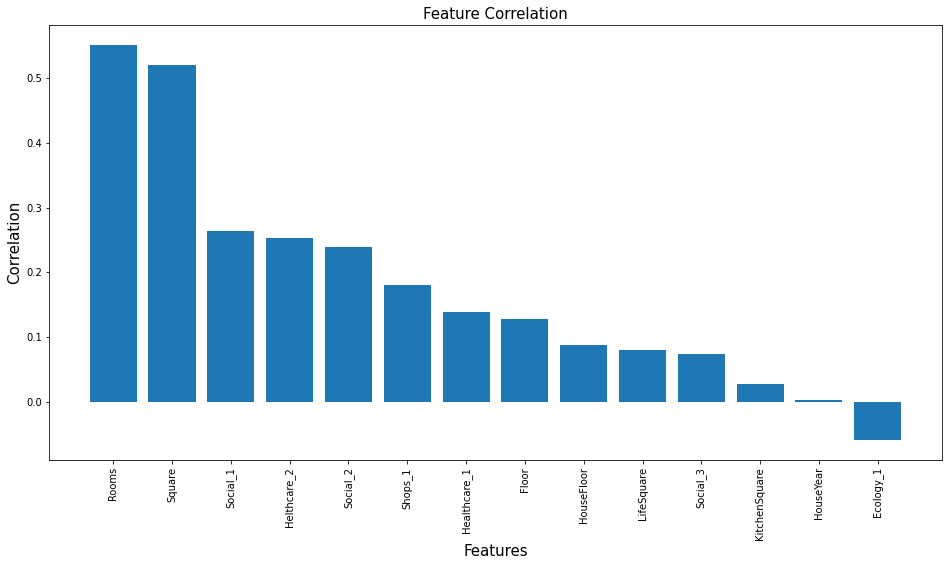

In [ ]:
# Prepare Data
correlation = df_train.corrwith(df_train['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

# Draw plot
plt.figure(figsize = (16,8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')

# Decorations    
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature Correlation', fontsize=15)
plt.show()

Максимальная корреляция у нас отображается в зависимости от количества комнат и площади.

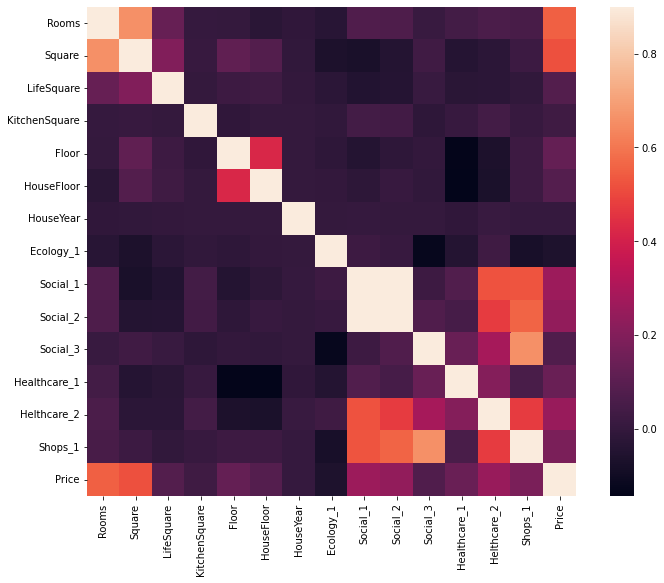

In [ ]:
corrmat = df_train.loc[:, df_train.columns != 'Id'].corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.9, square=True)

На хитмап также можно наблюдать, что максимальная корреляция у нас наблюдается в зависимости от площади и количества комнат (эти признаки коррелируют между собой.)

## Номинативные признаки

In [ ]:
nom_feat

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [ ]:
df_train['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
207      1
199      1
205      1
174      1
196      1
Name: DistrictId, Length: 205, dtype: int64

## Исправление данных

In [ ]:
df.loc[df['Floor'] > df['HouseFloor']]

NameError: ignored